<a href="https://colab.research.google.com/github/RidaMalik/Projects/blob/master/drugss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import files
uploaded = files.upload()


Saving METAB_training_disguised.csv to METAB_training_disguised.csv


In [38]:
import io
df_train = pd.read_csv(io.BytesIO(uploaded['METAB_training_disguised.csv']))

In [29]:
df_train.head()

,MOLECULE,Act,D_36,D_37,D_38,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_48,D_50,D_57,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_67,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_109,D_120,D_163,D_187,D_188,...,D_10667,D_10669,D_10671,D_10672,D_10673,D_10674,D_10675,D_10676,D_10677,D_10678,D_10679,D_10681,D_10682,D_10683,D_10684,D_10685,D_10693,D_10694,D_10695,D_10696,D_10697,D_10698,D_10699,D_10700,D_10701,D_10702,D_10704,D_10705,D_10706,D_10735,D_10736,D_10737,D_10738,D_10740,D_10741,D_10743,D_10744,D_10745,D_10746,D_10763
0,M_5058,70.00,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,M_6406,74.68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,M_12634,2.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,M_17594,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,M_17627,73.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1569 entries, 0 to 1568
Columns: 4374 entries, MOLECULE to D_10763
dtypes: float64(1), int64(4372), object(1)
memory usage: 52.4+ MB


In [39]:
df_train.describe()

,Act,D_36,D_37,D_38,D_39,D_41,D_42,D_43,D_44,D_45,D_46,D_48,D_50,D_57,D_58,D_59,D_60,D_61,D_62,D_63,D_64,D_65,D_66,D_67,D_68,D_69,D_70,D_71,D_72,D_73,D_74,D_75,D_76,D_77,D_109,D_120,D_163,D_187,D_188,D_189,...,D_10667,D_10669,D_10671,D_10672,D_10673,D_10674,D_10675,D_10676,D_10677,D_10678,D_10679,D_10681,D_10682,D_10683,D_10684,D_10685,D_10693,D_10694,D_10695,D_10696,D_10697,D_10698,D_10699,D_10700,D_10701,D_10702,D_10704,D_10705,D_10706,D_10735,D_10736,D_10737,D_10738,D_10740,D_10741,D_10743,D_10744,D_10745,D_10746,D_10763
count,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.00000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,...,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000
mean,46.204765,0.001275,0.011472,0.001275,0.001912,0.000637,0.000637,0.006373,0.003824,0.000637,0.003187,0.001275,0.000637,0.38942,0.019758,0.022307,0.018483,0.015296,0.035692,0.070108,0.041428,0.054175,0.031867,0.035054,0.221160,0.054812,0.045889,0.033142,0.033142,0.026131,0.012747,0.005099,0.008923,0.003824,0.003824,0.000637,0.001912,0.002549,0.005099,0.004461,...,0.007011,0.002549,0.005099,0.006373,0.003824,0.022945,0.007011,0.005099,0.001912,0.003187,0.001275,0.005099,0.001275,0.007648,0.000637,0.001275,0.010835,0.055449,0.030593,0.004461,0.002549,0.001275,0.014659,0.005736,0.002549,0.003824,0.008923,0.001912,0.001275,0.003824,0.001275,0.002549,0.002549,0.000637,0.001275,0.000637,0.007011,0.000637,0.000637,0.001275
std,36.061884,0.035692,0.185222,0.050492,0.043699,0.025246,0.025246,0.100814,0.061741,0.025246,0.066739,0.035692,0.025246,0.89964,0.189635,0.195972,0.148255,0.210734,0.271993,0.321714,0.279288,0.366307,0.234747,0.218809,0.709024,0.278120,0.284255,0.239947,0.257882,0.242132,0.155152,0.087333,0.123396,0.087398,0.107075,0.025246,0.075737,0.050443,0.079697,0.075630,...,0.149239,0.050443,0.071246,0.079605,0.061741,0.149774,0.083463,0.071246,0.043699,0.056379,0.035692,0.071246,0.035692,0.087147,0.025246,0.035692,0.103559,0.228928,0.179518,0.075630,0.050443,0.035692,0.120222,0.075544,0.050443,0.061741,0.094069,0.043699,0.035692,0.061741,0.035692,0.050443,0.050443,0.025246,0.035692,0.025246,0.083463,0.025246,0.025246,0.035692
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [40]:
df_train.columns

Index(['MOLECULE', 'Act', 'D_36', 'D_37', 'D_38', 'D_39', 'D_41', 'D_42',
       'D_43', 'D_44',
       ...
       'D_10736', 'D_10737', 'D_10738', 'D_10740', 'D_10741', 'D_10743',
       'D_10744', 'D_10745', 'D_10746', 'D_10763'],
      dtype='object', length=4374)

In [41]:
y = df_train['Act'].values
y = np.reshape(y, (-1, 1))
df_train = df_train.drop(['Act', 'MOLECULE'], axis = 1)
df_train = df_train.apply(lambda x: np.log(x+1))
x = df_train.values
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size = 0.80)

In [43]:
def r_square(X, Y):
    """ r^2 value defined by the competition host, r^2 = 1 indicates 100% prediction accuracy
    """
    avx = np.mean(X)
    avy = np.mean(Y)
    sum1, sumx, sumy = 0, 0, 0
    for i in range(len(X)):
        sum1 += (X[i] - avx)*(Y[i] - avy)
        sumx += (X[i] - avx)*(X[i] - avx)
        sumy += (Y[i] - avy)*(Y[i] - avy)
    print(len(X), sum1, sumx, sumy)
    return sum1*sum1/(sumx*sumy)

In [50]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import sys
import datetime
import random
from tensorflow.keras.models import Sequential
sys.stdout.write( "reading data ... ")
sys.stdout.flush()
start = datetime.datetime.now()
train_1 = pd.read_csv('METAB_training_disguised.csv',dtype={"MOLECULE": object, "Act": float})
stop = datetime.datetime.now()
sys.stdout.write( "done\n")
sys.stdout.write( "took {} seconds\n".format( ( stop - start ).total_seconds() ) )
sys.stdout.flush()

y = train_1['Act'].values
y = np.reshape(y, (-1, 1))
train_1 = train_1.drop(['Act', 'MOLECULE'], axis = 1)
#train_1 = train_1.apply(lambda x: 1 if x > 0 else 0)
#x = train_1.values
x = np.where(train_1 > 0, 1, 0)

seed = round(random.uniform(1, len(x)))
X_train, X_dev, Y_train, Y_dev = train_test_split(x, y, train_size = 0.80, random_state = seed)
X_val, X_test, Y_val, Y_test = train_test_split(X_dev, Y_dev, train_size = 0.50, random_state = seed)

X_placeholder = tf.placeholder(tf.float32, (None, X_train.shape[1]))
Y_placeholder = tf.placeholder(tf.float32, (None, Y_train.shape[1]))

# define parameters
features = np.shape(X_train)[1] # switch to X_train
target_size = np.shape(X_train)[0]

learning_rate = 0.001# switch to 0.05

epochs = 900
batch_size = 300

batch_size_placeholder = tf.placeholder(tf.int64)

# network parameters
n_hidden_1 = 100
n_hidden_2 = 50

ds_train = tf.data.Dataset.from_tensor_slices(( X_placeholder, Y_placeholder )).shuffle(buffer_size=round(len(X_train) * 0.3)).batch(batch_size_placeholder)

ds_test = tf.data.Dataset.from_tensor_slices(( X_placeholder, Y_placeholder )).batch( batch_size_placeholder )

ds_iter = tf.data.Iterator.from_structure(ds_train.output_types, ds_train.output_shapes)

next_x, next_y = ds_iter.get_next()

train_init_op = ds_iter.make_initializer(ds_train)
test_init_op = ds_iter.make_initializer(ds_test)

# define placeholder for input vector X and target vector y
keep_prob = tf.placeholder(tf.float32)

# initialize weights and bias  
weights = {'w1': tf.Variable(tf.truncated_normal([features, n_hidden_1], 0, 1, dtype=tf.float32)),
           'w2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], 0, 1, dtype=tf.float32)),
          'out': tf.Variable(tf.truncated_normal([n_hidden_2, 1], 0, 1, dtype=tf.float32))}

biases = {'b1': tf.Variable(tf.truncated_normal([n_hidden_1], 0, 1, dtype=tf.float32)),
          'b2': tf.Variable(tf.truncated_normal([n_hidden_2], 0, 1, dtype=tf.float32)),
         'out': tf.Variable(tf.truncated_normal([1], 0, 1, dtype=tf.float32))}

# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer 1 with ReLu activation
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_1 = tf.nn.dropout(layer_1, keep_prob) 
    
    # Hidden layer 2 with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_2 = tf.nn.dropout(layer_2, keep_prob) 
    
    # Output layer with ReLu activation
    out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
    return out_layer
              
# construct model
y_pred = multilayer_perceptron(next_x, weights, biases)

# define cost function(mean squred error) and optimizer(gradient descent)
cost =  tf.losses.mean_squared_error(next_y, y_pred)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# initialize variables
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    for epoch in range(epochs):

        sess.run(train_init_op, feed_dict={X_placeholder: X_train, Y_placeholder: Y_train, batch_size_placeholder: batch_size})
        count = 0

        while True:
            try:
                count += 1
                _, c = sess.run((optimizer, cost), feed_dict={keep_prob: 0.75})
                #print('Epoch:', (epoch + 1), 'Batch:', count, 'cost =', c)
            except tf.errors.OutOfRangeError:
                break
        print('Epoch:', (epoch + 1), 'cost =', c)
    sess.run(test_init_op, feed_dict={X_placeholder: X_test, Y_placeholder: Y_test, batch_size_placeholder: len(X_test)})

    results, test_cost = sess.run((y_pred, cost), feed_dict={keep_prob: 1.0})

    #for val in results:
        #print(val)

#    print(results)
    print(test_cost)
    print('R^2:', r_square(np.reshape(results, (len(results),)), Y_test))

Instructions for updating:
non-resource variables are not supported in the long term
reading data ... done
took 1.155667 seconds
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch: 1 cost = 232556.44
Epoch: 2 cost = 165446.16
Epoch: 3 cost = 167310.0
Epoch: 4 cost = 167310.4
Epoch: 5 cost = 96057.45
Epoch: 6 cost = 117631.7
Epoch: 7 cost = 103713.5
Epoch: 8 cost = 63300.67
Epoch: 9 cost = 83202.67
Epoch: 10 cost = 81481.81
Epoch: 11 cost = 57124.367
Epoch: 12 cost = 47482.2
Epoch: 13 cost = 52445.723
Epoch: 14 cost = 69519.96
E

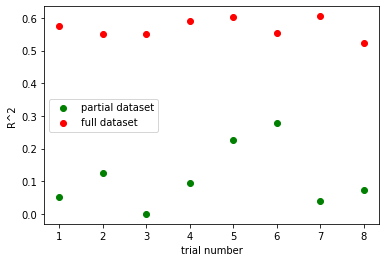

In [51]:
trials = [1, 2, 3, 4, 5, 6, 7, 8]
partial = [0.05283864, 0.12415486, 0.00022403, 0.09502669, 0.22610443, 0.27914648, 0.04014865, 0.07257308]
full = [0.5743373, 0.54912524, 0.55121789, 0.58873684, 0.60274144, 0.55380666, 0.6047694, 0.52323944]
plt.scatter(trials, partial, c='g')
plt.scatter(trials, full, c = 'r')
plt.xlabel('trial number')
plt.ylabel('R^2')
plt.legend(('partial dataset', 'full dataset'))

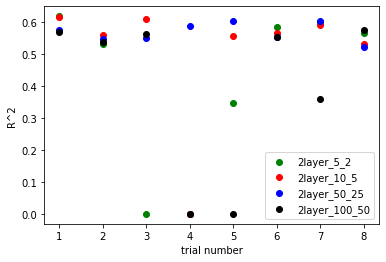

In [52]:
l2_5_2 = [0.61896012,0.53270644,3.06E-31,4.23E-05,0.3485523,0.58375834,0.59753719,0.56718316]
l2_10_5 = [0.61686939,0.55970689,0.61003986,0.00013259,0.55750357,0.56649397,0.59018233,0.53085809]
l2_50_25 = [0.5743373,0.54912524,0.55121789,0.58873684,0.60274144,0.55380666,0.6047694,0.52323944]
l2_100_50 = [0.56976497,0.53703742,0.56213195,3.27E-30,0,0.55265919,0.35860149,0.57682541]

trials = [1, 2, 3, 4, 5, 6, 7, 8]
plt.scatter(trials, l2_5_2, c = 'g')
plt.scatter(trials, l2_10_5, c = 'r')
plt.scatter(trials, l2_50_25, c = 'b')
plt.scatter(trials, l2_100_50, c = 'black')

plt.xlabel('trial number')
plt.ylabel('R^2')
plt.legend(('2layer_5_2', '2layer_10_5', '2layer_50_25', '2layer_100_50'))